<a href="https://colab.research.google.com/github/markwreinke/OrganStopClassifier/blob/main/OrganStopClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the actual organ stop classifier program.

In [1]:
# Start with the imports
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
import pickle
import IPython

In [2]:
# Mount GoogleDrive, cd and confirm current directory
from google.colab import drive
drive.mount("/content/drive")

dir = "/content/drive/My Drive/OrganStopDataset"
print(os.getcwd())

if(os.getcwd() != dir):
  os.chdir(dir)

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/My Drive/OrganStopDataset


In [3]:
# Here we are reading a comma separated values (CSV) file using pandas into the 
# variable df. df is type a 2D data structure with labeled axes, 
# as a DataFrame or TextParser
df = pd.read_csv('organstopClassifierDirectory.csv')

In [4]:
# Return the first n rows of the DataFrame. n defaults to 5 with no args
df.head(10)

,filename,fold,category_1,category_2
0,Hautbois8AT4051Left AT4051 WinLett.wav,1,Hautbois,AT4051
1,Hautbois8AT4051Left AT4051 WinLett-1.wav,2,Hautbois,AT4051
2,Hautbois8AT4051Left AT4051 WinLett-2.wav,3,Hautbois,AT4051
3,Hautbois8AT4051Left AT4051 WinLett-3.wav,4,Hautbois,AT4051
4,Hautbois8AT4051Left AT4051 WinLett-4.wav,5,Hautbois,AT4051
5,Hautbois8AT4051Left AT4051 WinLett-5.wav,1,Hautbois,AT4051
6,Hautbois8AT4051Left AT4051 WinLett-6.wav,2,Hautbois,AT4051
7,Hautbois8AT4051Left AT4051 WinLett-7.wav,3,Hautbois,AT4051
8,Hautbois8AT4051Left AT4051 WinLett-8.wav,4,Hautbois,AT4051
9,Hautbois8AT4051Left AT4051 WinLett-9.wav,5,Hautbois,AT4051


In [5]:
df.at[0, "category_1"]

'Hautbois'

In [6]:
# The data was sorted into 5 "Cross-validation" folds, in which here, the first
# four are used as training data, and the fifth is a validation set
# Here's the paper: http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [7]:
# Load a file with librosa, and display its sampling rate and length
wav, sr = librosa.load('SampleDataset/Krummhorn8AT4051Left-Live10 AT4051 Left.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 1.0 seconds


In [8]:
# Here we are going to convert a Spectrogram into an image
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

  # This spectrogram is normalized using z score normalization and 
  # scaled using min-max scaling so its values lie between 0 and 255

In [9]:
# This function give a mel spectrogram of the given file
#  sr=None -> Librosa should use the native sampling rate of 44.1KHz to load the audio data instead of the default of 22.05KHz

#  Next if the sample is less than num_sec long, it is padded with refected versions of itself - i.e., if num_sec is 5,and a 1 second clip is sent it, it will be changed to: clip + reversed clip + clip + reversed clip + clip.
# If the clip runtime is greater than num_sec, it will be truncated.

#  2048 samples are chosen for each window (about 46ms)
#  A hop_length of 512 samples is chose, meaning the window is moved by skipping 512 samples to get the next time frame
#  The number of mel filters is 128, makes the height of the spectrogram image 128
#  fmin and fmax are the lowest and highest frequencies
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80, num_sec = 1):
  wav, sr = librosa.load(file_path, sr=sr)
  if wav.shape[0]<num_sec*sr:
     wav=np.pad(wav,int(np.ceil((num_sec*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:num_sec*sr]

  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)

  #Librosa squares the magnitude of the spectrogram when constructing Mel Spectrogram, so we use power_to_db to convert power magnitude to decipels. top_db is used to threshold the output.
  spec_db=librosa.power_to_db(spec, top_db=top_db)
  return spec_db

In [10]:
print(type(sorted(df["category_1"].unique())))

<class 'list'>


In [11]:
# This is us loading data into pytorch by building dataloaders to
# preprocess and load data.
# I augmented it by getting it to save the filename as well

# Where Torch Dataloaders support Map-Style and Iterable-Style datasets, this one is a Map-style dataset as it implements __getitem__() and __len__() protocals, and s represents a mapp from indeices/keys to data samples.


class OrganStopSamples(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.filenames = []
    self.c2i = {} # This is a dictionary that maps Category:index
    self.i2c = {} # This is a dicitonary that maps index: category
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category] = i
      self.i2c[i] = category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base, row[in_col])
      # print("base: ", base, "\nin_col: ", in_col, "\nrow[in_col]: ", row[in_col], "\nfile_path:", file_path)
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...]) # This takes the mel_spectrogram of the current file and appends it to the data list, also adds a new dimension to the front of the data
      self.labels.append(self.c2i[row['category_1']]) # This is the sister list of the data list, in which it maps the category to the data of the corresponding index of the data list.
      self.filenames.append(file_path) #Sace the filename

  def __len__(self):
     return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
  def __getFileName__(self, idx):
    return self.filenames[idx]


In [12]:
# Load up the training data
train_data = OrganStopSamples('SampleDataset', train, 'filename', 'category_1')
valid_data = OrganStopSamples('SampleDataset', valid, 'filename', 'category_1')


train_loader = DataLoader(train_data, batch_size = 16, shuffle = True, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size = 16, shuffle = True, pin_memory=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


{'Hautbois': 0, 'Krummhorn8': 1, 'Principal8': 2, 'Trumpette8': 3}
{0: 'Hautbois', 1: 'Krummhorn8', 2: 'Principal8', 3: 'Trumpette8'}
2179
<class 'list'>
test:
87
(array([[[181, 172, 157, ..., 149, 161, 135],
        [192, 173, 131, ..., 144, 148, 133],
        [190, 163, 150, ..., 161, 140, 118],
        ...,
        [ 23,  16,  26, ...,  18,  14,  31],
        [ 36,  28,  20, ...,  20,  20,  20],
        [ 24,  27,  22, ...,  20,  20,   9]]], dtype=uint8), 0)
<class 'numpy.ndarray'>


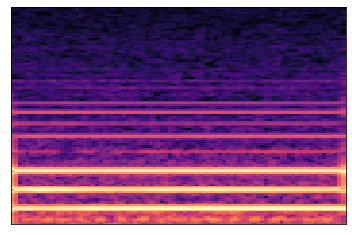

In [13]:
print(train_data.c2i)
print(train_data.i2c)
print(len(train_data.labels))
print(type(train_data.labels))

print("test:")
print(len(train_data.__getitem__(0)[0][0][0]))

print(train_data.__getitem__(3))
print(type(train_data.__getitem__(0)[0]))
#librosa.display.specshow(train_data.__getitem__(0)[0][0])
librosa.display.specshow(train_data.__getitem__(3)[0][0])

In [14]:
# This is its own model, not the resnet34
class OrganStopModel(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=4):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [15]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [16]:
model = OrganStopModel(input_shape=(1,128,87), batch_size=16, num_cats=4).to(device)

In [17]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 60
train_losses = []
valid_losses = []

In [18]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  return optimizer

In [19]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [20]:
print(model)

OrganStopModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [21]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer


In [22]:
# Train the model
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch - 1 Train-Loss : 0.10729323375764487
Epoch - 1 Valid-Loss : 0.039680860125158424 Valid-Accuracy : 0.9926470588235294
Epoch - 2 Train-Loss : 0.012571069051959403
Epoch - 2 Valid-Loss : 0.029974988539299162 Valid-Accuracy : 0.9926470588235294
Epoch - 3 Train-Loss : 0.004813230971805326
Epoch - 3 Valid-Loss : 0.015849291161109304 Valid-Accuracy : 0.9963235294117647
Epoch - 4 Train-Loss : 0.001580313242851658
Epoch - 4 Valid-Loss : 0.02623704284451378 Valid-Accuracy : 0.9908088235294118
Epoch - 5 Train-Loss : 0.0010005486054693513
Epoch - 5 Valid-Loss : 0.01889252937042543 Valid-Accuracy : 0.9926470588235294
Epoch - 6 Train-Loss : 0.00047640018382593633
Epoch - 6 Valid-Loss : 0.017189152450180913 Valid-Accuracy : 0.9963235294117647
Epoch - 7 Train-Loss : 0.0005645734508883848
Epoch - 7 Valid-Loss : 0.018447614777388106 Valid-Accuracy : 0.9944852941176471
Epoch - 8 Train-Loss : 0.00017174679340938503
Epoch - 8 Valid-Loss : 0.018146103265173547 Valid-Accuracy : 0.9944852941176471
Epoch

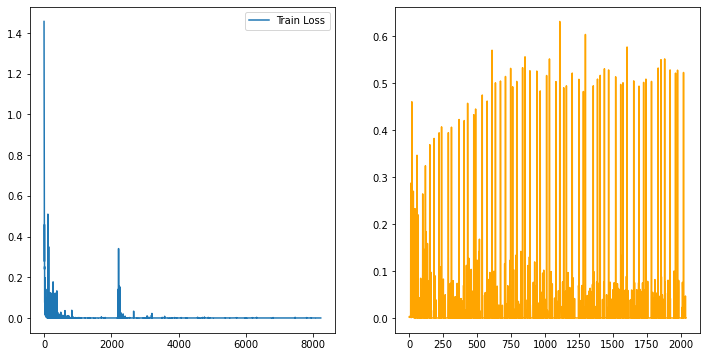

In [23]:
# Here we plot the Train losses, where blue is the training loss, and orange is the validation loss
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(["Train Loss"])
plt.subplot(1, 2, 2)
plt.plot(vl, "orange")

In [24]:
# Let's save the trained model
with open("organStopModel.pth", 'wb') as f:
  torch.save(model, f)

f.close()

In [25]:
# Save the traindata dataloader's I2C attribute as a file
import pickle
with open('organTrainDataloaderI2C.pkl', 'wb') as f2:
  pickle.dump(train_data.i2c, f2)

f2.close()

In [26]:
print(type(train))

<class 'function'>


84/380 of the samples were marked as "Failed"

I am not sure if the comparison that determines this is mapping samples to labels correctly or not however. Some samples sounded like they were Krummhorn8, were marked as that, but were marked as incorrect.

I also discovered that the Krummhorn8EarthworksRight files failed to export correctly, resulting in in its samples to be silent.

As of 11/24/2020 I need to retrain the model with the fixes to the Krummhorn8EarthR samples and retest and see what the result is.

Another discrepency is that the final layer of the model has 50 nodes, which doesn't align with the current number of categories (3 at the moment)


11/25/2020
Changed testing segment to own file. Doesn't work yet

11/27/2020
It appears to work! I had to change the mel_spectrogram function to accept 1 second clips, as well as augment the "input_shape" argument into the model.